<h1>Derivatives Cash Flow</h1>

<h3>Benjamin Ford</h3>

In [1]:
### Preamble

## Packages
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Dataset
cashflow = pd.read_excel("Cashflow Model.xlsx")

Assumptions: <br>
- Start date: 31st March 2021
- GBPUSD Volatility: 10% (assuming annualised)
- Zero drift
- Starting Price: GBPUSD = 1.3925
- 5 years, 252 days a year to match option later

**a)	Using the Monte Carlo method, simulate 1000 paths across time for the GBPUSD FX spot rate, using the Geometric Brownian Motion (GBM) model.**<br> 
<br>
Here we use the Euler discretisation of Geometric Brownian Motion (source: *Python for Algorithmic Trading, Yves Hilpisch* - I am lucky enough to have a copy on my desk)<br>
>$S_{t} = S_{t-1}\exp{((r - 0.5\sigma^2)dt + \sigma z \sqrt{dt})}$

<br>Using a function for the ease in later code of readability

In [2]:
class MonteCarloSimulationOfFXRisk:

    def __init__(S0, r, sigma, T, steps, sims = 5000)
            S0 = S0
            r = r
            T = T
            sigma = sigma
            steps = steps
            sims = sims
        
        
    def geometricBrownianMotionPaths(self):
        
            '''
            Function to produce n (sims) Monte Carlo Simulations of Geometric Brownian Motion
            
            Parameters
            ==========
            S0 = Start date price level
            r = risk-free rate
            sigma = volatility
            T = time horizon
            steps = number of steps in the simulation
            sims = simulations
            
            Returns
            =======
            GBPUSD
            '''
            
            
            
            dt = T / steps
            
            # Empty(ish) holding array: steps + 1 days (252*5 days), by the amount of simulations we wish to run
            GBPUSD = np.zeros((steps + 1, sims)) 
            
            # Initialise our starting price for the GBM
            GBPUSD[0] = S0
            
            # Running over our day set
            for days in range(1, steps + 1): 
                randomNumber = np.random.standard_normal(sims)    
                GBPUSD[days] = GBPUSD[days - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
                                                        + sigma * np.sqrt(dt) * randomNumber)
                
            return GBPUSD

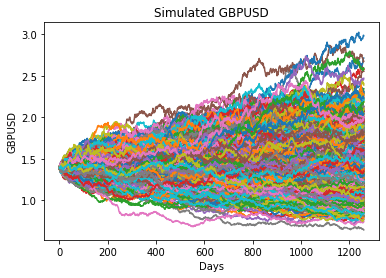

In [3]:
simulatedPaths = geometricBrownianMotionPaths(S0 = 1.3925, r = 0, sigma = 0.1, T = 5, steps = 5*252, sims = 1000)
plt.plot(simulatedPaths) # X-axis: day count (simulations); Y-axis: price level of GBPUSD
plt.xlabel('Days')
plt.ylabel('GBPUSD')
plt.title('Simulated GBPUSD')
plt.show()

**b)	Using the simulated FX spot rate paths, convert the GBP cashflows into fund currency (USD) and calculate the corresponding IRR (internal rate of return) for each of the simulated paths. Plot the distribution of the IRR and evaluate the 95%, 50% and 5% percentiles.**<br>
<br>Here, I create a way to hold our simulation, via an array, placing the cashflows in column order and then ending with the IRR for the respective row.

In [4]:
# We can grab each years simulation set and convert the GBP cashflow, additional for each IRR of each simulated FX spot rate
GBPCashflows = np.zeros((1000, cashflow.shape[0] + 1)) #1000 Simulations, 6 CFs, 1 IRR

# Fill up our array with the cash flows, simulated 1000 times
for cashflows in range(0, (cashflow.shape[0])): 
    GBPCashflows[:, cashflows] = simulatedPaths[252 * cashflows,] * cashflow['Cashflow Amount (in Local Asset Currecny)'][cashflows]

# End column for each simulated cash flow value represents the respective IRR
for path in range(0, len(GBPCashflows)):
    GBPCashflows[path, (len(GBPCashflows[0]) - 1)] = npf.irr(GBPCashflows[path,])

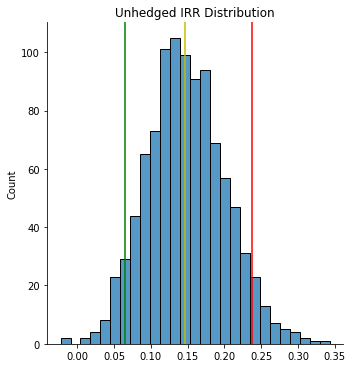

[0.23748208319338018, 0.14690533953212015, 0.06411311607741141]


In [5]:
# Plot the histogram and add quantiles
sns.displot(GBPCashflows[:, (len(GBPCashflows[0]) - 1)])
plt.axvline(np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.95), color='r')
plt.axvline(np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.50), color='y')
plt.axvline(np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.05), color='g')
plt.title('Unhedged IRR Distribution')
plt.show()
plt.show()
quants = [np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.95), np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.50), np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.05)]
print(quants)

**c)	Assume we would like to buy a GBPUSD European Put option to hedge our FX exposure. If the USD and GBP risk-free (interest) rates are 0% throughout the time horizon of the fund, how can we use the simulated FX spot rate paths to calculate the option’s fair market value (premium) on the trade date. See the option details below:**<br>
- **Trade Date: 31/03/2021**
- **Expiry Date: 31/03/2026**
- **Notional Amount: 100,000,000 GBP**
- **Strike: 1.3925**
<br>
<br>
Need last step of the simulation and compare against the strike.


In [6]:
putPremium = np.mean(np.maximum(1.3925 - simulatedPaths[-1], 0))
Notional = 100000000 #GBP
print("Put premium ($):");putPremium*Notional # discounting isn't needed as rate = 0%

Put premium ($):


12010888.841845408

**d)	Calculate the IRR of the hedged portfolio, including the option premium payment you calculated in (c) and the option payoff. Looking at the distribution of the hedged portfolio IRR, assess the impact of the Put option on the portfolio FX risk.**<br>
<br>
Here we assess the impact of the option on the portfolio, implmenting the cost of the option on our cashflows.  Given the option is European we only concentrate on the 0th and last cashflow.

In [7]:
# We can grab each years simulation set and convert the GBP cashflow, additional for each IRR of each simulated FX spot rate
GBPCashflowsHedged = np.zeros((1000, cashflow.shape[0] + 1)) #1000 Simulations, 6 CFs, 1 IRR
GBPCashflowsHedged[:,0] = GBPCashflowsHedged[:,0] - putPremium*Notional # Paying the premium

# Fill up our array with the cash flows, simulated 1000 times
for cashflows in range(0, (cashflow.shape[0])): 
    GBPCashflowsHedged[:, cashflows] = GBPCashflowsHedged[:, cashflows] + simulatedPaths[252 * cashflows,] * cashflow['Cashflow Amount (in Local Asset Currecny)'][cashflows]

# If the put will be exercised, then add the exercisable payoff
GBPCashflowsHedged[:,5] = GBPCashflowsHedged[:,5] + np.where(simulatedPaths[-1] < 1.3925, 1.3925 - simulatedPaths[-1], 0)*100000000    

# End column for each simulated cash flow value represents the respective IRR
for path in range(0, len(GBPCashflowsHedged)):
    GBPCashflowsHedged[path, (len(GBPCashflowsHedged[0]) - 1)] = npf.irr(GBPCashflowsHedged[path,])

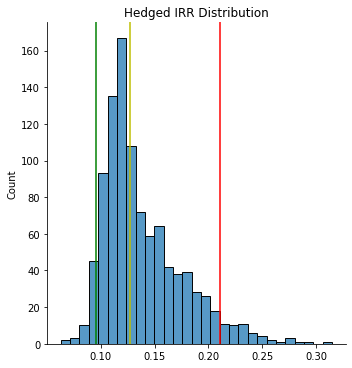

[0.21065707190968955, 0.1275953656668648, 0.09588582019780227]


In [8]:
# Plot the histogram and add quantiles
sns.displot(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)])
plt.axvline(np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.95), color='r')
plt.axvline(np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.50), color='y')
plt.axvline(np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.05), color='g')
plt.title('Hedged IRR Distribution')
plt.show()
quantsHedged = [np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.95), 
                np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.50), 
                np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.05)]
print(quantsHedged)

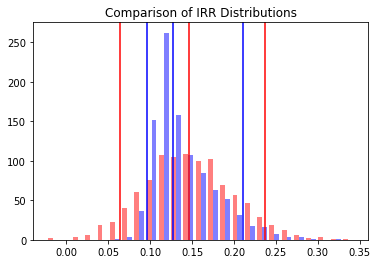

In [9]:
# Quick comparison with percentiles
plt.hist([GBPCashflows[:, (len(GBPCashflows[0]) - 1)], GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)]], color=['r','b'], alpha=0.5, bins = 25)
# Unhedged in red
plt.axvline(np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.95), color='r')
plt.axvline(np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.50), color='r')
plt.axvline(np.quantile(GBPCashflows[:, (len(GBPCashflows[0]) - 1)], 0.05), color='r')
# Hedged in blue
plt.axvline(np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.95), color='b')
plt.axvline(np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.50), color='b')
plt.axvline(np.quantile(GBPCashflowsHedged[:, (len(GBPCashflowsHedged[0]) - 1)], 0.05), color='b')
plt.title('Comparison of IRR Distributions')
plt.show()

Without considering any risk-adjusted metrics it's evident that hedging with this put option, under MCS, has rewarded with both a semi-fat tail/semi-leptokurtic (in comparison the unhedged distribution) in the desirable tail.  Furthermore, it has shrunk the losing tail.  That is, the major variability comes in the right hand side of the distribution and an investor can be provided with far more confident minimum expectations of their returns. <br>
What has the put option done?  It has enabled us to protect the client from downside risk if the pound depreciates against the dollar.  As a result, where cashflows are reduced in value, due to FX risk, we can remove such via the put option.